<a href="https://colab.research.google.com/github/WenyiYao/cryptocurrency/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np

In [43]:
df = pd.read_json('poolDayData_0.json')
df.head()

,id,high,low,tvlUSD,txCount,volumeUSD,date,open,tick,close
0,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19251,0.787862,0.829892,390558.121780,63,47603.628095,2022-09-16,0.825782,-278530,0.807040
1,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19252,0.796931,0.829426,391985.894464,43,25969.275749,2022-09-17,0.807040,-278202,0.824302
2,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19253,0.756814,0.829987,374113.451267,64,39271.628388,2022-09-18,0.824302,-279093,0.750910
3,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19254,0.727532,0.778021,377515.557429,97,74419.312606,2022-09-19,0.750910,-278972,0.765373
4,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19255,0.722816,0.765373,369165.264073,56,45400.579439,2022-09-20,0.765373,-279395,0.735607


In [44]:
df = df.drop(columns=["id"])
df = df.set_index(['date'])
df.head()

,high,low,tvlUSD,txCount,volumeUSD,open,tick,close
date,,,,,,,,
2022-09-16,0.787862,0.829892,390558.121780,63,47603.628095,0.825782,-278530,0.807040
2022-09-17,0.796931,0.829426,391985.894464,43,25969.275749,0.807040,-278202,0.824302
2022-09-18,0.756814,0.829987,374113.451267,64,39271.628388,0.824302,-279093,0.750910
2022-09-19,0.727532,0.778021,377515.557429,97,74419.312606,0.750910,-278972,0.765373
2022-09-20,0.722816,0.765373,369165.264073,56,45400.579439,0.765373,-279395,0.735607


In [45]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'])])
fig.show()

In [46]:
dataset = df.values
dataset

array([[ 7.87862287e-01,  8.29892477e-01,  3.90558122e+05, ...,
         8.25781924e-01, -2.78530000e+05,  8.07040060e-01],
       [ 7.96930701e-01,  8.29426013e-01,  3.91985894e+05, ...,
         8.07040060e-01, -2.78202000e+05,  8.24302185e-01],
       [ 7.56813753e-01,  8.29986952e-01,  3.74113451e+05, ...,
         8.24302185e-01, -2.79093000e+05,  7.50909829e-01],
       ...,
       [ 6.87838526e-01,  7.38167099e-01,  3.59513332e+05, ...,
         6.94514893e-01, -2.79577000e+05,  7.25942301e-01],
       [ 7.10644868e-01,  7.43249712e-01,  3.59720647e+05, ...,
         7.25942301e-01, -2.79292000e+05,  7.60861060e-01],
       [ 6.62648431e-01,  8.23300917e-01,  3.75465258e+05, ...,
         7.60861060e-01, -2.78565000e+05,  0.00000000e+00]])

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [48]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+1:(i+look_back+1),[0,1,7]]) #predict high, low, and close
    return numpy.array(dataX), numpy.array(dataY)

In [49]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [50]:
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [51]:
print(trainX.shape)
print(trainY.shape)

(288, 4, 8)
(288, 4, 3)


In [52]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [65]:
batch_size = 8
model0 = Sequential()
model0.add(LSTM(6, batch_input_shape=(batch_size, look_back, 8), stateful=True, return_sequences=True))
model0.add(TimeDistributed(Dense(3)))
model0.compile(loss='mean_squared_error', optimizer='adam')

# Lists to store loss values
train_loss_values = []
test_loss_values = []

for i in range(25):
    # Train the model and collect training loss
    history_train = model0.fit(trainX, trainY, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    train_loss_values.extend(history_train.history['loss'])

    # Evaluate the model on the test set and collect test loss
    test_loss = model0.evaluate(testX, testY, batch_size=batch_size, verbose=0)
    test_loss_values.append(test_loss)

    model0.reset_states()

Epoch 1/10
36/36 - 2s - loss: 0.1434 - 2s/epoch - 57ms/step
Epoch 2/10
36/36 - 0s - loss: 0.0589 - 147ms/epoch - 4ms/step
Epoch 3/10
36/36 - 0s - loss: 0.0299 - 112ms/epoch - 3ms/step
Epoch 4/10
36/36 - 0s - loss: 0.0222 - 109ms/epoch - 3ms/step
Epoch 5/10
36/36 - 0s - loss: 0.0196 - 93ms/epoch - 3ms/step
Epoch 6/10
36/36 - 0s - loss: 0.0178 - 99ms/epoch - 3ms/step
Epoch 7/10
36/36 - 0s - loss: 0.0161 - 99ms/epoch - 3ms/step
Epoch 8/10
36/36 - 0s - loss: 0.0145 - 98ms/epoch - 3ms/step
Epoch 9/10
36/36 - 0s - loss: 0.0130 - 96ms/epoch - 3ms/step
Epoch 10/10
36/36 - 0s - loss: 0.0116 - 90ms/epoch - 3ms/step
Epoch 1/10
36/36 - 0s - loss: 0.0106 - 106ms/epoch - 3ms/step
Epoch 2/10
36/36 - 0s - loss: 0.0094 - 103ms/epoch - 3ms/step
Epoch 3/10
36/36 - 0s - loss: 0.0084 - 114ms/epoch - 3ms/step
Epoch 4/10
36/36 - 0s - loss: 0.0077 - 95ms/epoch - 3ms/step
Epoch 5/10
36/36 - 0s - loss: 0.0071 - 95ms/epoch - 3ms/step
Epoch 6/10
36/36 - 0s - loss: 0.0067 - 106ms/epoch - 3ms/step
Epoch 7/10
36/36 

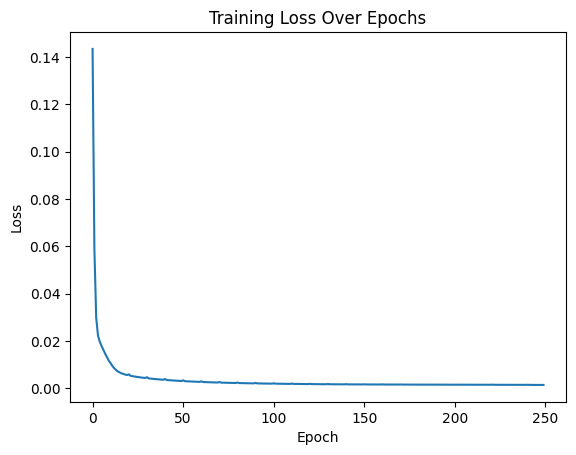

In [66]:
# Plot the train loss values
plt.plot(train_loss_values)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

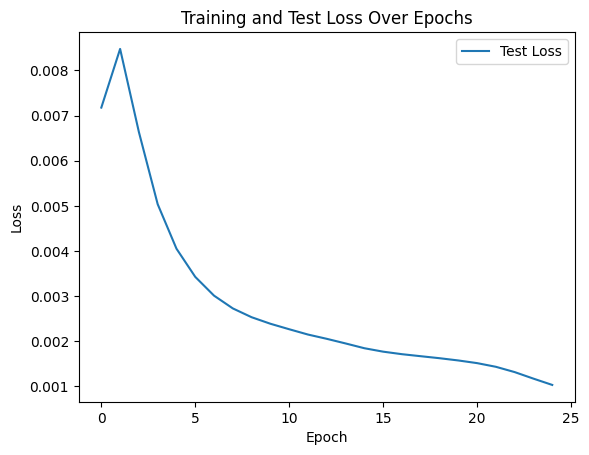

In [67]:
# Plot the test loss values
plt.plot(test_loss_values, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
model0.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (8, 4, 6)                 360       
                                                                 
 time_distributed_5 (TimeDi  (8, 4, 3)                 21        
 stributed)                                                      
                                                                 
Total params: 381 (1.49 KB)
Trainable params: 381 (1.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
trainPredict = model0.predict(trainX, batch_size=batch_size)
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 0], trainPredict[:, -1, 0]))
print('Train Score of high value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 1], trainPredict[:, -1, 1]))
print('Train Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 2], trainPredict[:, -1, 2]))
print('Train Score of close value: %.10f RMSE' % (trainScore))
model0.reset_states()

36/36 [==============================] - 1s 3ms/step
Train Score of high value: 0.0327612679 RMSE
Train Score of low value: 0.0269965666 RMSE
Train Score of close value: 0.5871114680 RMSE


In [70]:
testPredict = model0.predict(testX, batch_size=batch_size)
testScore = math.sqrt(mean_squared_error(testY[:, -1, 0], testPredict[0:testY.shape[0], -1, 0]))
print('Test Score of high value: %.2f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(testY[:, -1, 1], testPredict[0:testY.shape[0], -1, 1]))
print('Test Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(testY[:, -1, 2], testPredict[0:testY.shape[0], -1, 2]))
print('Test Score of close value: %.10f RMSE' % (trainScore))

16/16 [==============================] - 1s 3ms/step
Test Score of high value: 0.02 RMSE
Test Score of low value: 0.0235950982 RMSE
Test Score of close value: 0.0460741955 RMSE


In [71]:
print(trainPredict.shape)
print(trainY.shape)

(288, 4, 3)
(288, 4, 3)


In [72]:
print(testPredict.shape)
print(testY.shape)

(128, 4, 3)
(121, 4, 3)


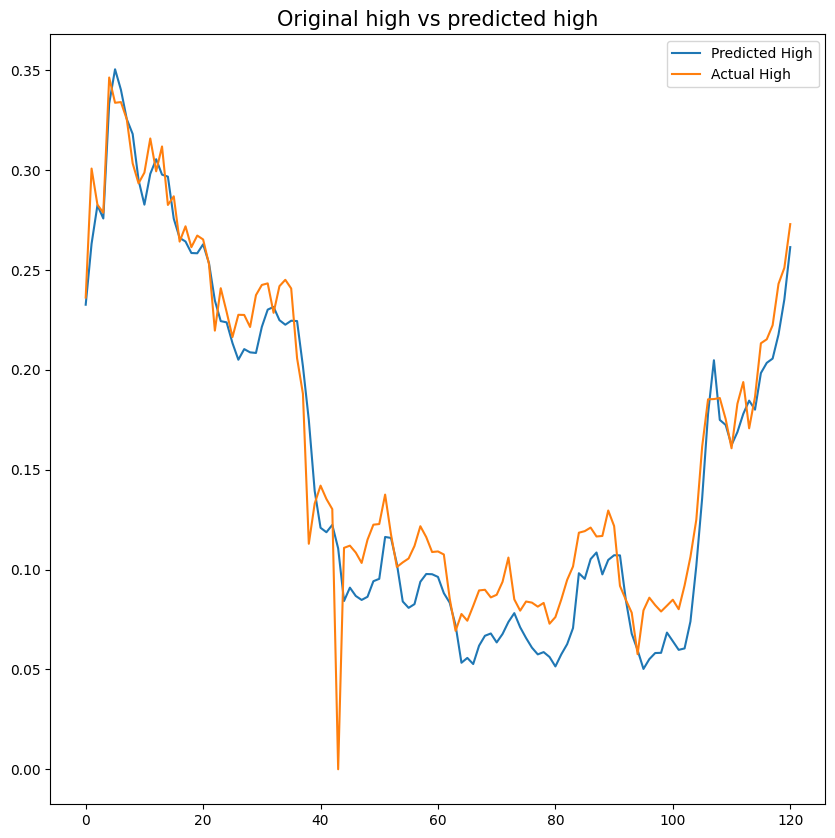

In [80]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 0], label='Predicted High')
plt.plot(testY[:, -1, 0], label='Actual High')
plt.title('Original high vs predicted high', fontsize=15)
plt.legend()
plt.show()

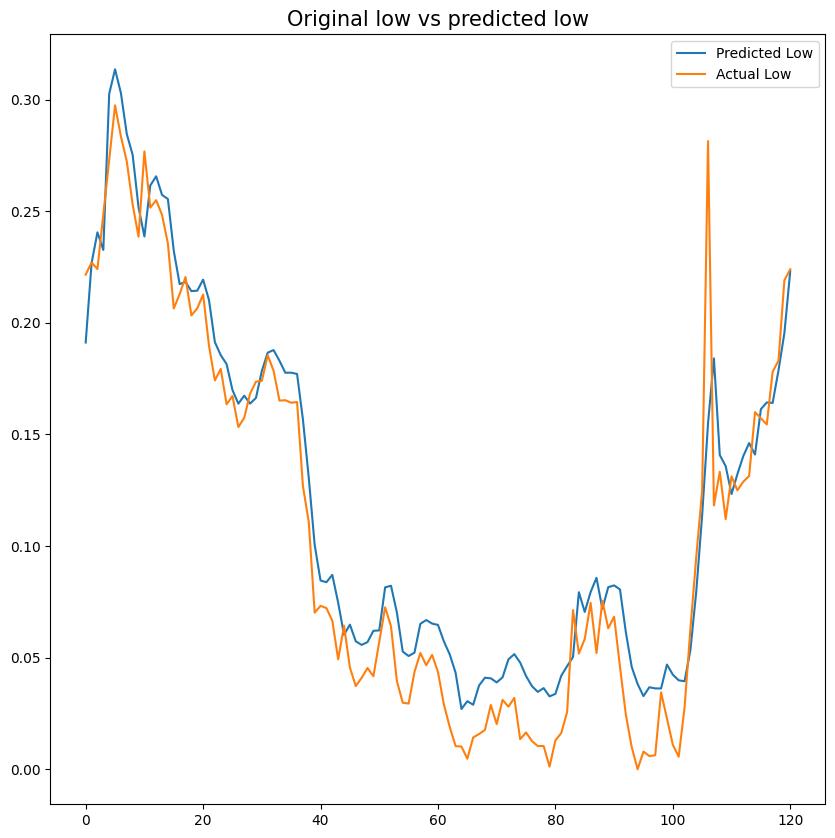

In [79]:
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 1], label='Predicted Low')
plt.plot(testY[:, -1, 1], label='Actual Low')
plt.title('Original low vs predicted low', fontsize=15)
plt.legend()
plt.show()

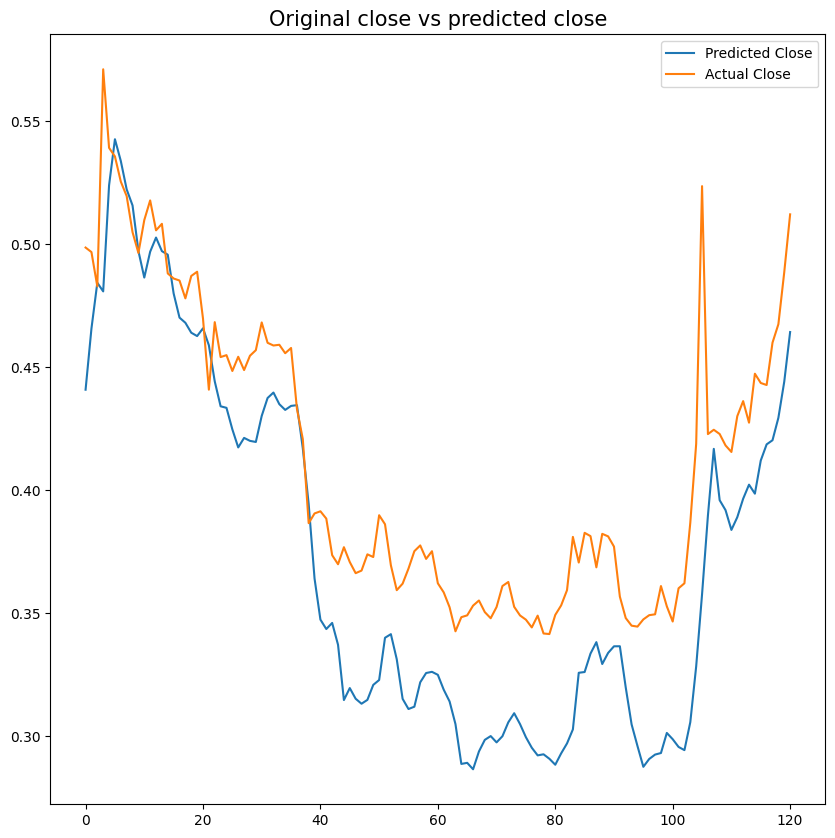

In [81]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 2], label='Predicted Close')
plt.plot(testY[:, -1, 2], label='Actual Close')
plt.title('Original close vs predicted close', fontsize=15)
plt.legend()
plt.show()